In [1]:
# !git clone https://github.com/tctianchi/pyvenn.git --q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyvenn import venn
import re, csv
from pathlib import os
from glob import glob
from typing import Literal

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
import plotnine as pn

In [5]:
%matplotlib inline

In [6]:
expression_data = pd.read_csv('glioma_cancer_exprs.csv', index_col=0)
metadata = pd.read_csv('glioma_cancer_metadata.csv')

In [ ]:
# load differential genes for each grade comparison
cell_dge_results = []
for x in 'MGC*vs*.csv|AC*vs*.csv|EC*vs*.csv'.split('|'):
    cell_dge_results.extend(glob(x))

In [72]:
# getting differential genes
selected_genes = []
for i in cell_dge_results:
    file = pd.read_csv(i, index_col=0)
    if len(file) > 1:
        selected_genes.extend(file.index.tolist())

selected_genes = list(set(selected_genes))

In [73]:
len(selected_genes)

10259

In [74]:
# selecting genes in expression data
expression_data = expression_data.loc[selected_genes,:]

In [75]:
# transpose expression data
expression_data = expression_data.T

In [76]:
# checking if positions of samples in metadata corresponds with that in expression data
all(metadata.sample_id == expression_data.index)

True

In [77]:
metadata.head()

,sample_id,tumor_class,tumor_grade,gse_id,tumor_type
0,GSM3242216,glioblastoma,G4,GSE116520,malignant
1,GSM3242217,glioblastoma,G4,GSE116520,malignant
2,GSM3242218,glioblastoma,G4,GSE116520,malignant
3,GSM3242219,glioblastoma,G4,GSE116520,malignant
4,GSM3242220,glioblastoma,G4,GSE116520,malignant


In [83]:
# recode tumour class
metadata['cell_type'] = (metadata.tumor_class
                         .str.replace('glioblastoma|astrocytoma|oligoastrocytoma', 'astrocytoma', regex=True)
                         .str.replace('oligo.+glioma$', 'oligodendrocytoma', regex=True)
                        )

In [92]:
# filter out normal and high grade glioma samples (high grade glioma because we don't know the type of glial cell it is)
cell_samples = metadata.query(f'cell_type not in {["normal", "high grade glioma"]}').sample_id.tolist()

In [93]:
len(cell_samples)

694

In [94]:
expression_data = expression_data.loc[cell_samples,:]
metadata = metadata.query(f'sample_id in {cell_samples}')

In [98]:
metadata.cell_type.value_counts()

cell_type
astrocytoma          498
ependymoma           118
oligodendrocytoma     63
mixed gliomas         15
Name: count, dtype: int64

__Visualise gene expressions by tumour cell type__

- Using PCA decomposition

In [99]:
pca = PCA(random_state=42, svd_solver='full')
X_pca = pca.fit_transform(scale(expression_data))

In [100]:
# variance ratio
exp_var = pca.explained_variance_ratio_

['Astrocytoma', 'Ependymoma', 'Mixed Gliomas', 'Oligodendrocytoma']

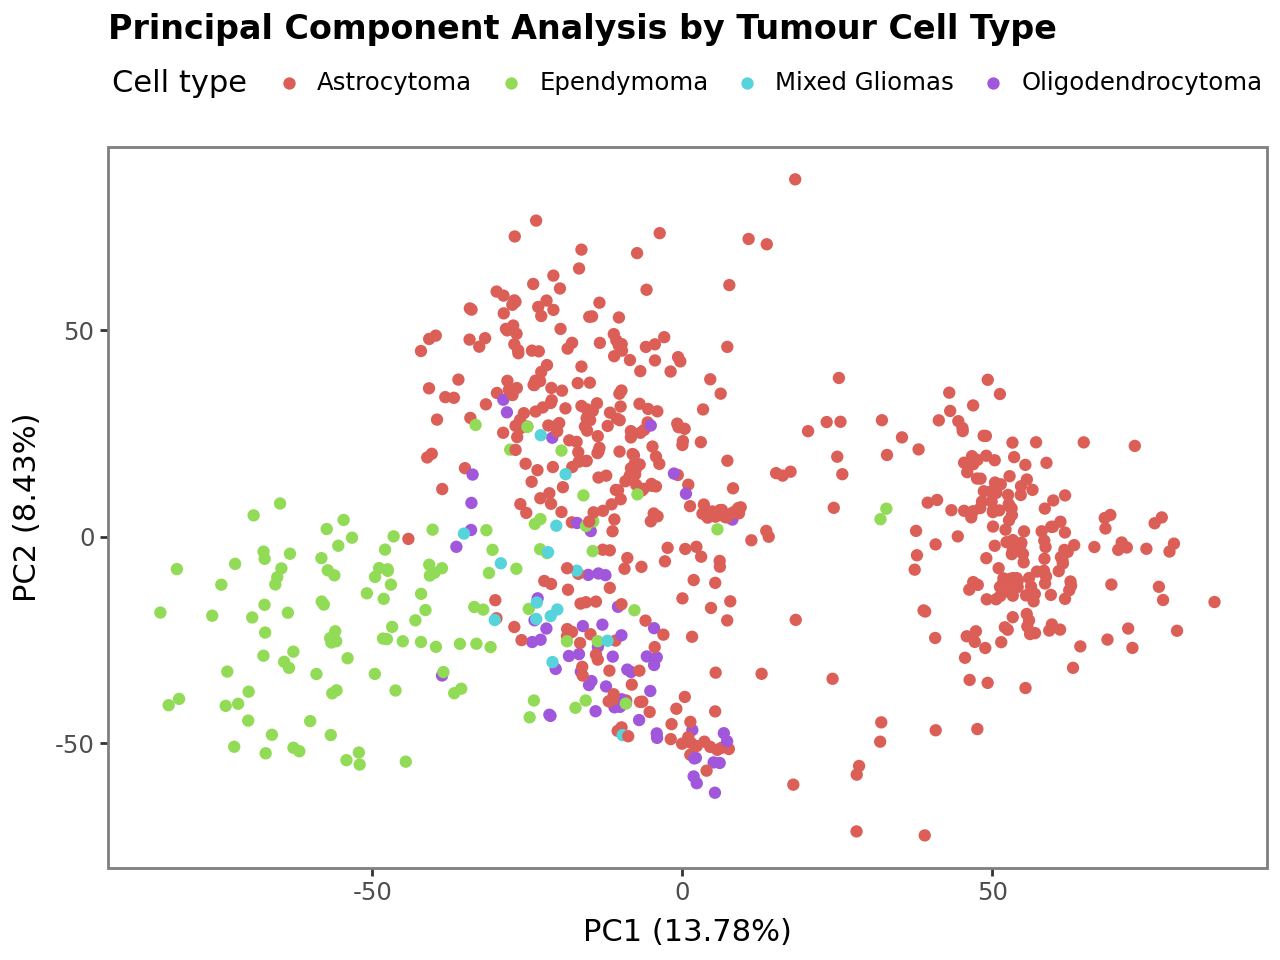

In [114]:
(
    pn.ggplot(pd.concat([
        pd.DataFrame(X_pca[:,:2], columns=['PC1', 'PC2']),
        metadata.cell_type.reset_index(drop=True)
    ], axis=1), 
              pn.aes('PC1', 'PC2', color='cell_type')) +
    pn.geom_point() +
    pn.theme_bw() +
    pn.theme(panel_grid=pn.element_blank(), 
             plot_title=pn.element_text(face='bold', size=12, hjust=0),
             legend_position= 'top',
             legend_key=pn.element_blank()) + 
    pn.labs(title='Principal Component Analysis by Tumour Cell Type', 
            x = f'PC1 ({exp_var[0]*100:.2f}%)',
            y = f'PC2 ({exp_var[1]*100:.2f}%)',
            color='Cell type') +
    pn.scale_color_discrete(labels=np.unique(metadata.cell_type.str.title()).tolist())
)

### __Splitting into train and test__

In [116]:
# get target class
target_var = metadata.cell_type

In [117]:
xtrain, xtest, ytrain, ytest = train_test_split(expression_data, 
                                                target_var, 
                                                test_size=0.25,
                                                stratify=target_var,
                                                random_state=43)

__Helper functions__

In [118]:
[i for i in metrics.get_scorer_names() if 'roc' in i or 'f1' in i]

['f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted']

In [119]:
def tune_parameters(model, X, y, param_grid, scorer='roc_auc_ovr_weighted', cv=5):
    gcv = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scorer)
    gcv.fit(X, y)
    return gcv

In [120]:
def specificity(preds, 
                actual, 
                unique_class=None, 
                average_type:Literal['weighted','micro', 'macro']='weighted'):
        # class specificity tn / (tn+fp)
        if unique_class is None:
             unique_class = sorted(np.unique(actual))
        tn = np.array([np.sum((preds != i) & (actual != i)) for i in sorted(unique_class)])
        fp = np.array([np.sum((preds != i) & (actual == i)) for i in sorted(unique_class)])
        score = tn / (tn+fp)
        class_counts = np.array([np.sum(actual==i) for i in sorted(unique_class)])
        
        if average_type == 'weighted':
            return np.average(score, weights=class_counts)
        elif average_type == 'macro':
            return np.mean(score)
        elif average_type == 'micro':
             return np.sum(tn) / np.sum(tn+fp)
        else:
             print(f'{average_type} not valid')
             exit(1)

In [204]:
def print_classification_report(model, X, y):
    preds = model.predict(X)
    print(metrics.classification_report(y, preds, zero_division=0.))

def eval_metrics(model, X, y, average_type='weighted'):
    preds = model.predict(X)
    unique_class = np.unique(preds)
    probs = model.predict_proba(X)
    acc = np.mean(y == preds)
    auc = metrics.roc_auc_score(y, probs, multi_class='ovr', average=average_type)
    rec = metrics.recall_score(y, preds, average=average_type, zero_division=0.)
    prec = metrics.precision_score(y, preds, average=average_type, zero_division=0.)
    f1 = metrics.f1_score(y, preds, average=average_type, zero_division=0.)
    spec = specificity(preds, y, unique_class, average_type)

    scores = pd.DataFrame([acc, auc, rec, prec, f1, spec], 
                          columns=['scores'], 
                          index=['Accuracy', 'AUC', 'Recall', 
                                 'Precision', 'F1', 'Specificity'])
    return scores.T

In [201]:
def performance_chart_report(model, x, y, display_labels=None):
    uniq_class = sorted(set(y))

    if display_labels is not None:
        display_labels = sorted(display_labels)
    else:
        display_labels = uniq_class

    probas = model.predict_proba(x)
    preds = model.predict(x)
    cm = pd.DataFrame(metrics.confusion_matrix(y, preds), index=uniq_class, columns=uniq_class)
    fig, ax = plt.subplots(1, 3, figsize=(11,4.3))
    for i in range(len(uniq_class)):
        y_clas = np.where(y == uniq_class[i], 1, 0)    
        auc = metrics.roc_auc_score(y_clas, probas[:,i])
        pr_score = metrics.average_precision_score(y_clas, probas[:,i])
        precision, recall, _ = metrics.precision_recall_curve(y_clas, probas[:,i])
        fpr, tpr, _ = metrics.roc_curve(y_clas, probas[:,i])

        ax[0].plot(fpr, tpr, label=display_labels[i] + f' (AUC={auc:.2f})')
        ax[1].plot(recall, precision, label=display_labels[i] + f' (PR={pr_score:.2f})')
        ax[0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
        ax[0].set_title('ROC curve', fontsize=10)
        ax[1].set(xlabel='Recall', ylabel='Precision')
        ax[1].set_title('Precision-Recall curve', fontsize=10)
    
    sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, ax=ax[2], 
                linecolor='k', square=True, fmt='.0f')
    ax[2].set_yticklabels(display_labels, rotation=0)
    ax[2].set_xticklabels(display_labels, rotation=0)
    ax[2].set(xlabel='Predicted Class', ylabel='Actual Class')
    ax[2].set_title('Confusion matrix', fontsize=10)
    
    fig.suptitle(model.__class__.__name__, fontweight='bold', x=0.12)
    fig.tight_layout()
    
    ax[0].legend(loc='lower right')
    ax[1].legend(loc='lower left')

In [176]:
def topn_importance(model, coef_num =None, topn=20):
    if hasattr(model, 'coef_'):
        varimp = model.coef_.squeeze()[coef_num]
        varimp = pd.Series(varimp, model.feature_names_in_).abs()
    elif hasattr(model, 'feature_importances_'):
        varimp = model.feature_importances_
        varimp = pd.Series(varimp, model.feature_names_in_)

    if topn is not None:
        varimp = varimp.nlargest(topn)
    varimp = varimp[varimp != 0] 
    varimp = varimp.reset_index(name='scores')
    varimp = varimp.rename(columns={'index':'gene'})

    fig = (
        pn.ggplot(varimp, pn.aes('reorder(gene, scores)', 'scores')) +
        pn.geom_col(fill='indianred') +
        pn.geom_text(pn.aes(label='scores'), fontweight='normal', size=8, 
                     format_string='{:.3f}', color='black', 
                     nudge_y=-max(varimp.iloc[:, 1])*0.03) + 
        pn.theme_bw() +
        pn.theme(panel_grid=pn.element_blank(),
                 figure_size=(7,4.5),
                 axis_title=pn.element_text(size=9),
                 axis_text=pn.element_text(size=8),
                 axis_text_x = pn.element_blank(),
                 axis_ticks_x = pn.element_blank(),
                 plot_title=pn.element_text(face='bold', hjust=0, size=12)) +
        pn.coord_flip() +
        pn.labs(title=model.__class__.__name__, 
                x='', y='scores')
        )
    return(fig)

In [236]:
display_labels = ['AC', 'EP', 'MGC', 'OGC']

### __Feature selection__

- Using Lasso logistic regression method
- Using a random forest model to recursively select features until feature importance scores are above zero.

__Logistic Regression__

In [124]:
lr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=500, random_state=42)

In [125]:
lr_model = Pipeline([('scaler', StandardScaler()),
                      ('model', lr)])

lambdas = {'model__C' : [0.1, 0.5, 0.8, 1, 1.5, 2, 2.5, 5, 10, 100]}

In [126]:
lr_res = tune_parameters(lr_model, xtrain, ytrain, lambdas)

In [127]:
lr_res.cv_results_['mean_test_score']

array([0.95252305, 0.94979327, 0.94755286, 0.94670443, 0.9451567 ,
       0.94426925, 0.94393548, 0.9425817 , 0.93922529, 0.93548275])

In [128]:
lr_res.best_params_, lr_res.best_score_

({'model__C': 0.1}, 0.9525230541317651)

In [129]:
lr.set_params(**{'C' : 0.1})

LogisticRegression(C=0.1, max_iter=500, penalty='l1', random_state=42,
                   solver='liblinear')

In [130]:
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_scaled = pd.DataFrame(scaler.transform(xtrain), 
                             columns=xtrain.columns, 
                             index=xtrain.index)

xtest_scaled = pd.DataFrame(scaler.transform(xtest), 
                            columns=xtest.columns, 
                            index=xtest.index)

In [131]:
lr.fit(xtrain_scaled, ytrain)

LogisticRegression(C=0.1, max_iter=500, penalty='l1', random_state=42,
                   solver='liblinear')

In [132]:
(lr.coef_.squeeze() != 0).sum(1)

array([68, 33,  7, 55])

In [134]:
select_features_cell = [expression_data.columns[(lr.coef_ != 0)[i]].tolist() for i in range(4)]

- A one vs rest (OVR) multiclass model is fitted on the train data.
- OVR - Binary type where a class is set as 1 and the others as 0
- Models are fit for each class

In [135]:
f = []
for i in select_features_cell: f.extend(i)
f = sorted(set(f))

In [136]:
len(f)

141

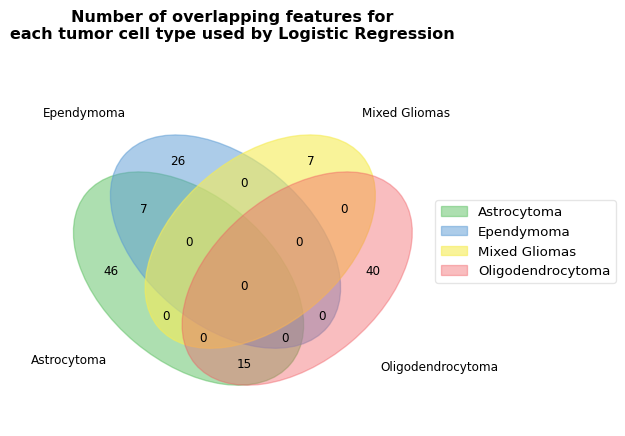

In [139]:
labs = venn.get_labels(select_features_cell, fill='number')
fig, ax = venn.venn4(labs, names=sorted(np.unique(metadata.cell_type.str.title())), 
                     figsize=(10,5), fontsize=9)
fig.suptitle('Number of overlapping features for\neach tumor cell type used by Logistic Regression', fontweight='bold');

- Selected genes are unique to each cell type except for astrocytoma and ependymoma and astrocytoma and oligodendroglioma where there are 7 and 15 overlapping genes, respectively
- This could be genes that are important for cell differentiation.

In [ ]:
def get_overlap_genes(genes, name='astrocytoma', other_grades=['oligodendrocytoma']):
    grade_map = {'astrocytoma':0, 'ependymoma':1, 'mixed glioma':2, 'oligodendrocytoma':3}
    
    # get genes of grade of interest
    grade_of_interest = set(genes[grade_map[name]])
    for i in other_grades:
        grade_of_interest.intersection_update(grade_of_interest, set(genes[grade_map[i]]))

    return(sorted(grade_of_interest))

In [ ]:
# astrocytoma vs oligodendrocytoma
print(get_overlap_genes(select_features_cell))

['ARID5A', 'C1orf162', 'CAPN12', 'DCLK3', 'DEFB126', 'FMR1NB', 'MTBP', 'NANOS3', 'RAP1A', 'SAGE1', 'SLA2', 'SLC22A6', 'TLX1', 'TMIGD2', 'ZNF526']


In [ ]:
# astrocytoma vs ependymoma 
print(get_overlap_genes(select_features_cell, other_grades=['ependymoma']))

['ABTB2', 'EFCAB1', 'HOXA10', 'LPAR3', 'PLA2G5', 'RPP38', 'SPTB']


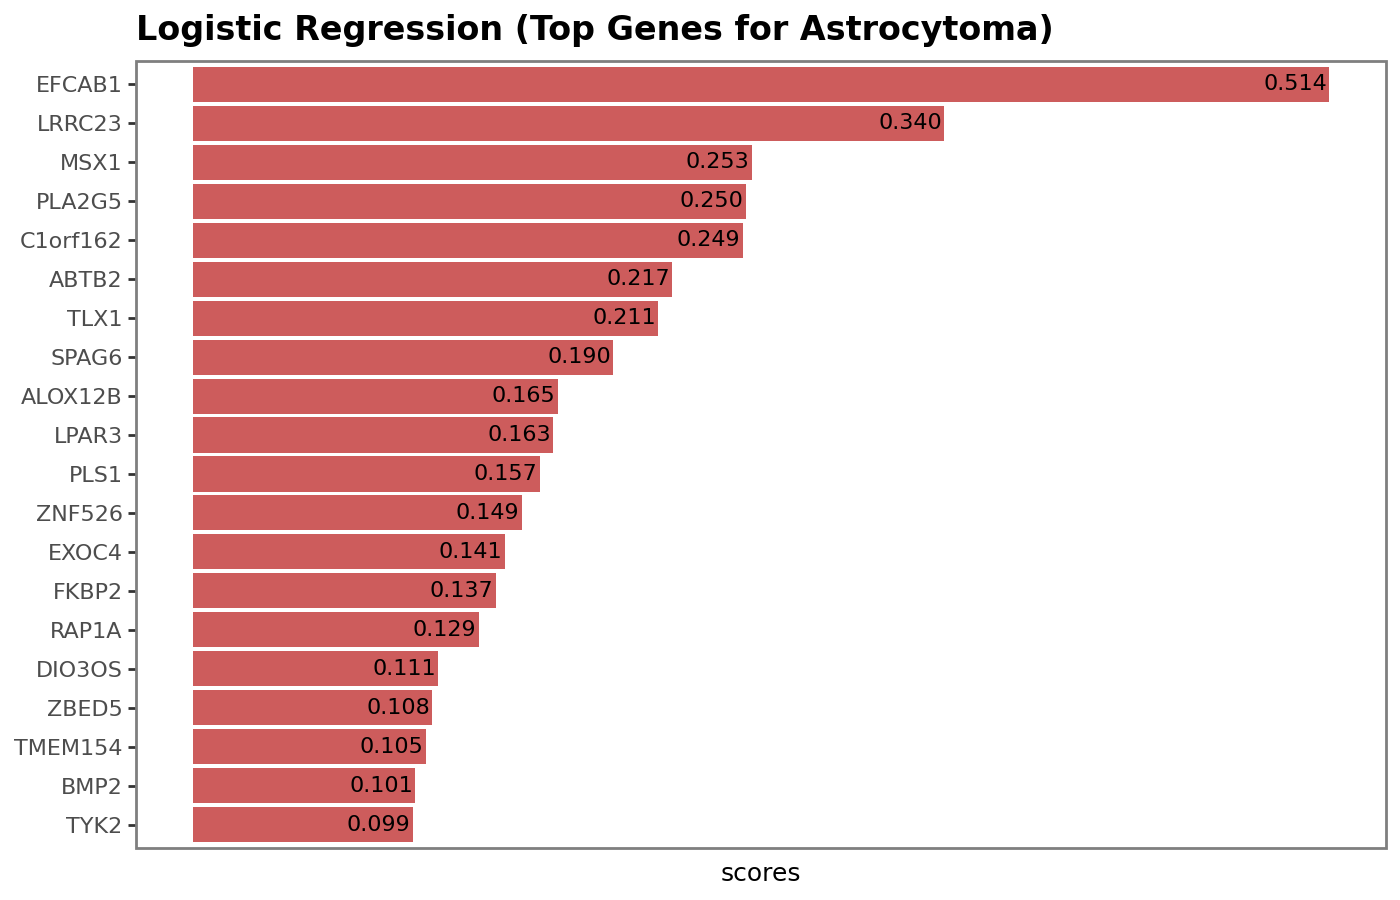

In [177]:
topn_importance(lr, coef_num=0) + pn.labs(title='Logistic Regression (Top Genes for Astrocytoma)')

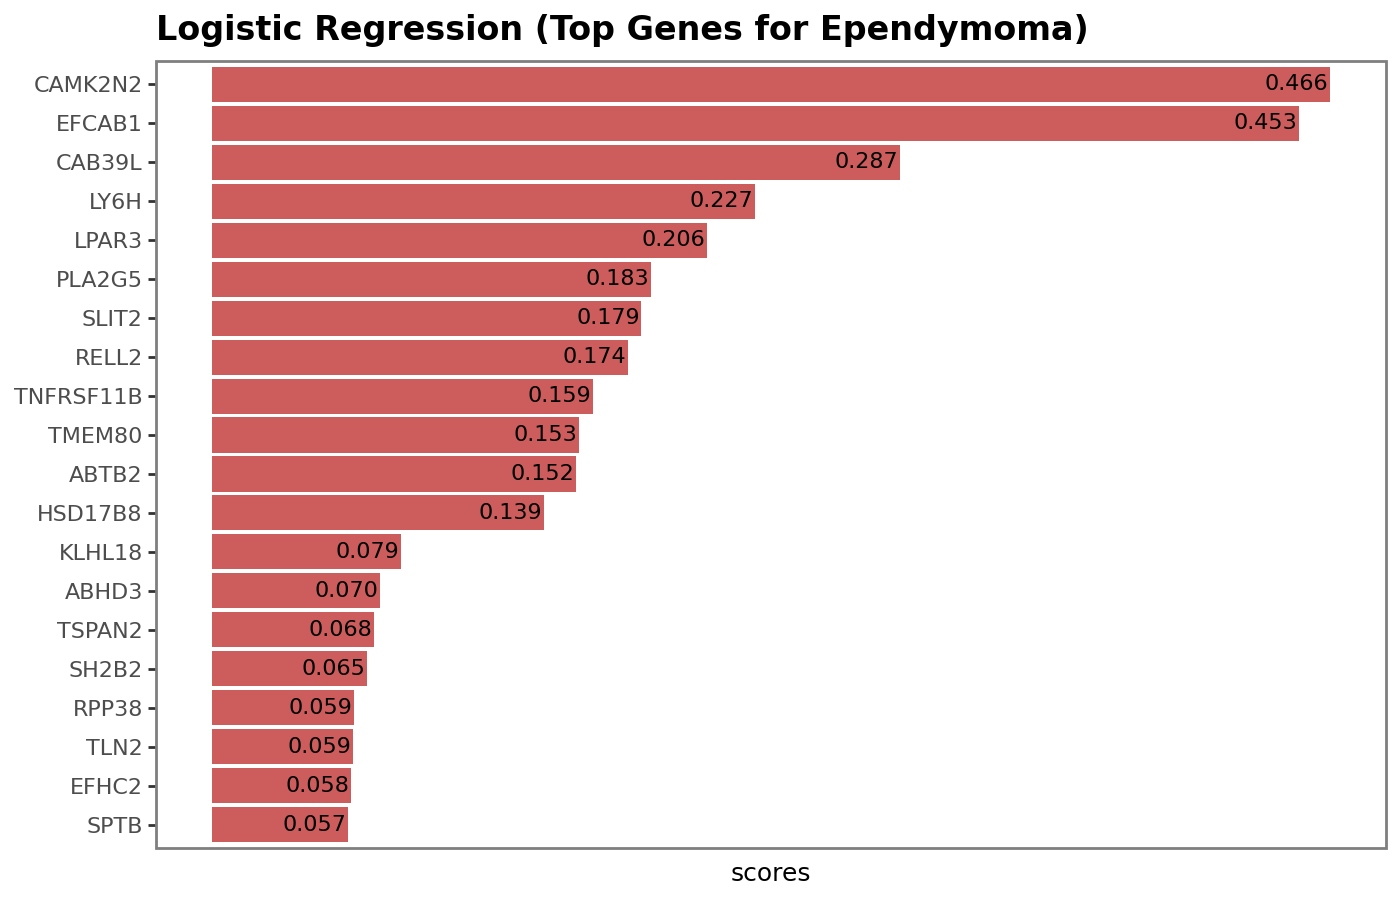

In [178]:
topn_importance(lr, coef_num=1) + pn.labs(title='Logistic Regression (Top Genes for Ependymoma)')

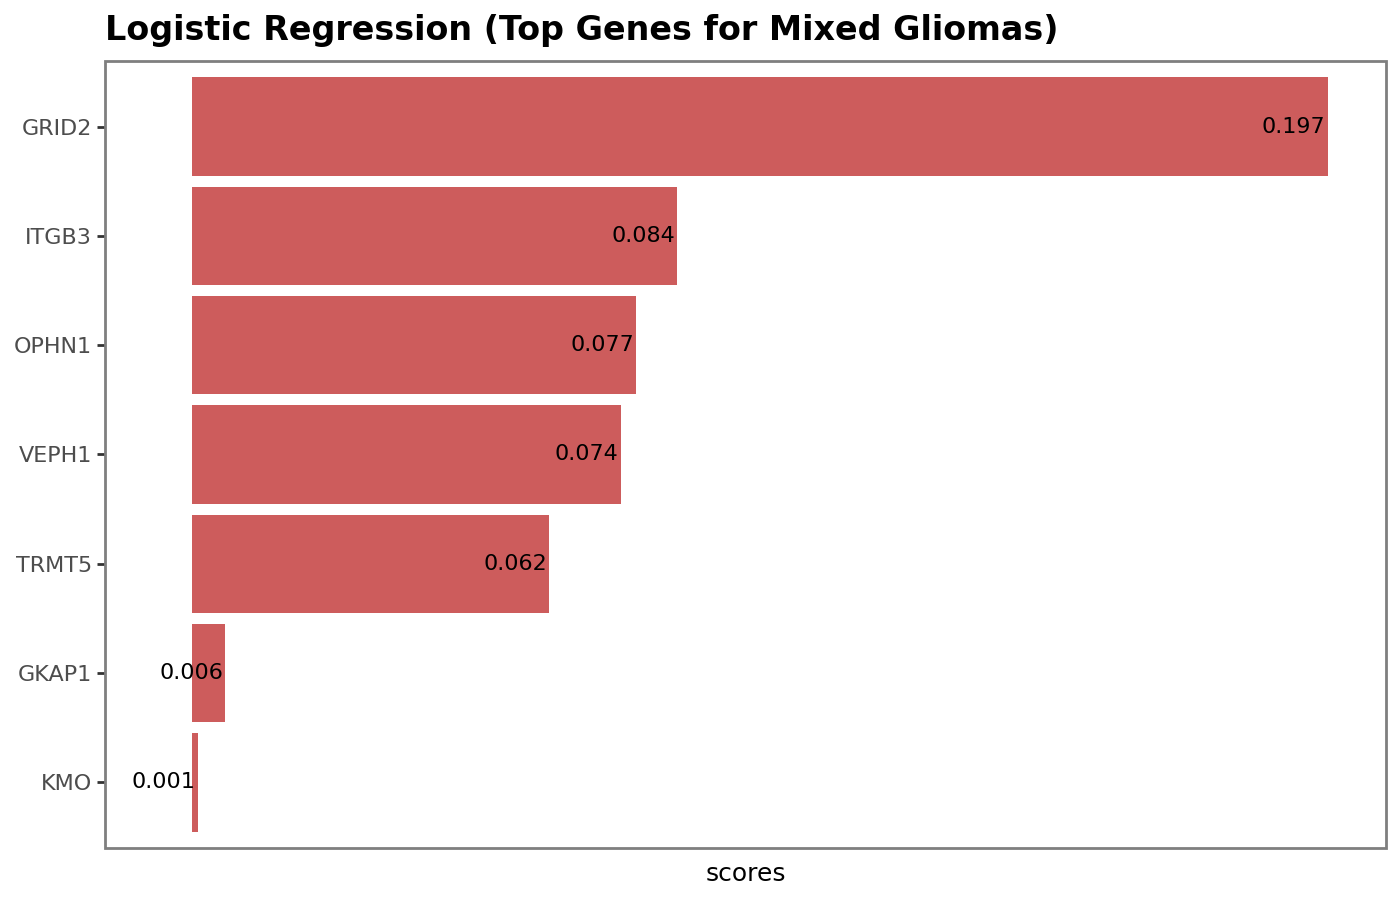

In [179]:
topn_importance(lr, coef_num=2) + pn.labs(title='Logistic Regression (Top Genes for Mixed Gliomas)')

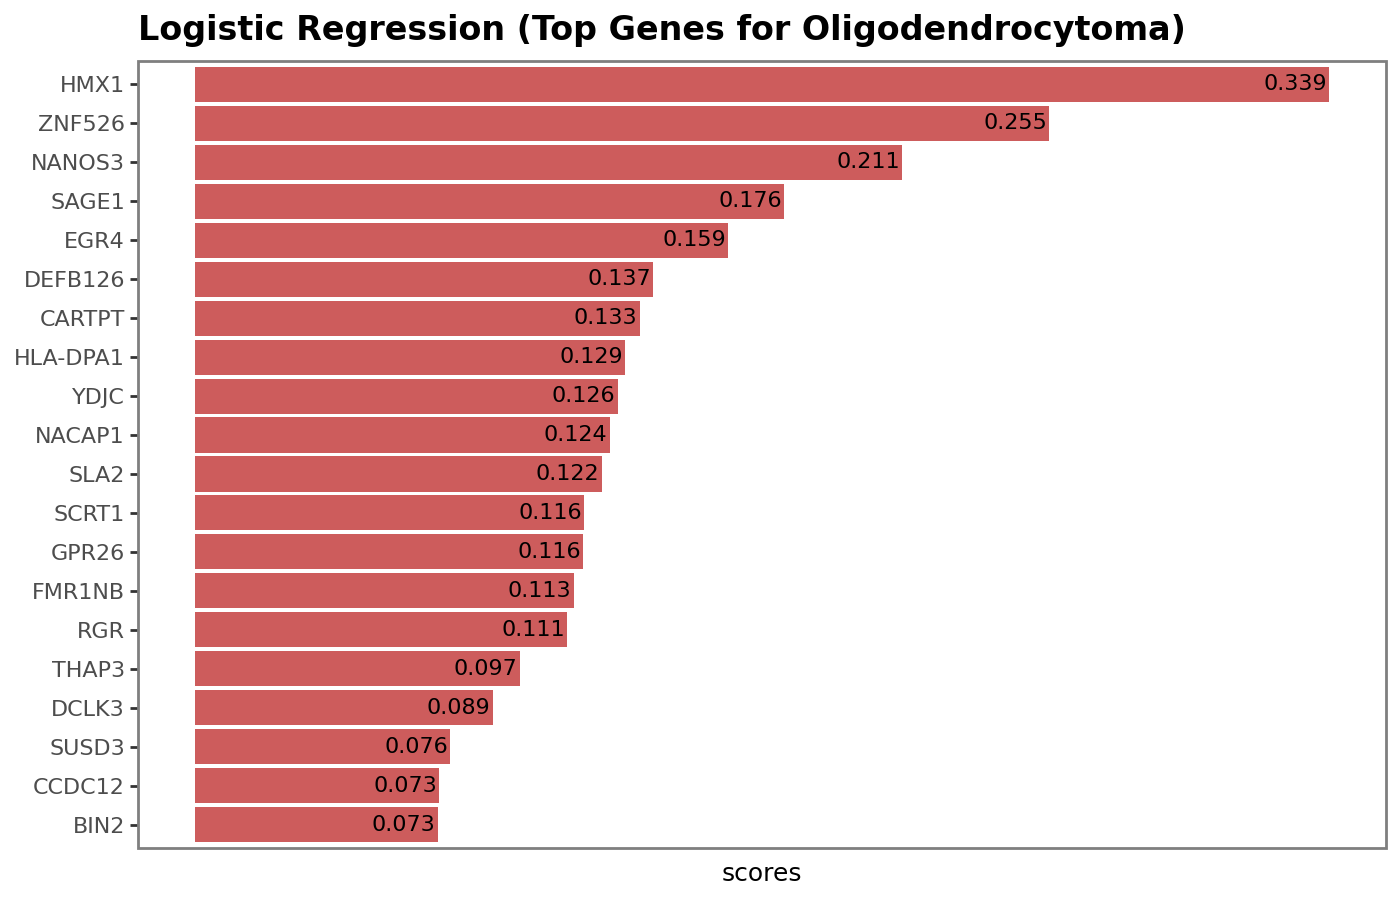

In [180]:
topn_importance(lr, coef_num=3) + pn.labs(title='Logistic Regression (Top Genes for Oligodendrocytoma)')

In [188]:
print(eval_metrics(lr, xtest_scaled, ytest, average_type='weighted'))

        Accuracy       AUC   Recall  Precision        F1  Specificity
scores   0.91954  0.958044  0.91954   0.895321  0.904553     0.942156


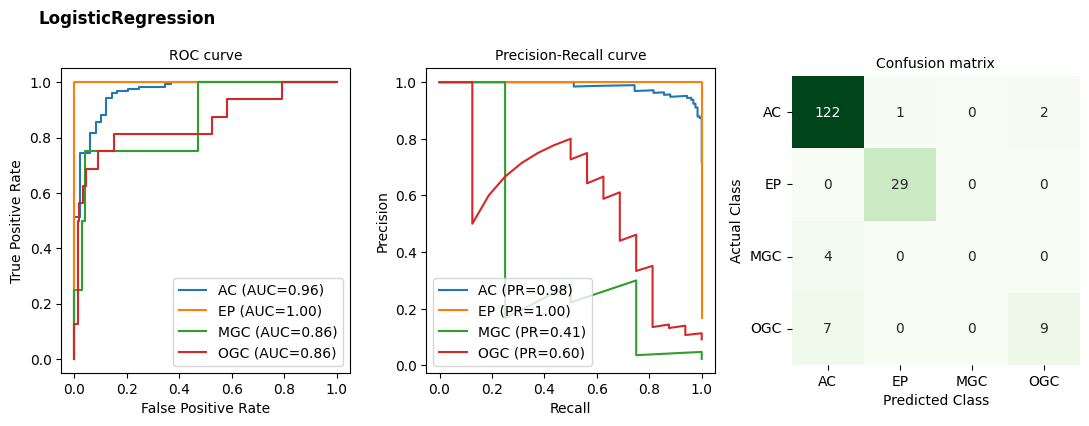

In [237]:
performance_chart_report(lr, xtest_scaled, ytest, display_labels)

In [205]:
print_classification_report(lr, xtest_scaled, ytest)

                   precision    recall  f1-score   support

      astrocytoma       0.92      0.98      0.95       125
       ependymoma       0.97      1.00      0.98        29
    mixed gliomas       0.00      0.00      0.00         4
oligodendrocytoma       0.82      0.56      0.67        16

         accuracy                           0.92       174
        macro avg       0.68      0.63      0.65       174
     weighted avg       0.90      0.92      0.90       174



__Random Forest Model__

We will recursively run a random forest model to drop features that are zero and below

In [210]:
rf = RandomForestClassifier(random_state=42, n_jobs=2)

In [207]:
rf.fit(xtrain, ytrain)

var_imp = pd.Series(rf.feature_importances_, 
                    index=rf.feature_names_in_)

In [ ]:
while any(var_imp <= 0):
    temp_features = var_imp[var_imp > 0].index.tolist()
    rf.fit(xtrain[temp_features], ytrain)
    
    var_imp = pd.Series(rf.feature_importances_, 
                        index=rf.feature_names_in_)

    if all(var_imp > 0):
        break

In [209]:
# confirm if all importance scores are greater than 0
print(all(var_imp > 0))

print(len(temp_features)) # num of selected features

True
467


In [211]:
rf_params = {
    'n_estimators' : [200,400, 500],
    'max_features' : [0.05, 0.1, 0.2],
    'min_samples_split' : [2,5,7],
    'min_samples_leaf' : [1,2,7]
}

In [212]:
rf_res = tune_parameters(rf, xtrain[temp_features], ytrain, rf_params)

In [213]:
rf_res.best_params_, rf_res.best_score_

({'max_features': 0.2,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 0.9758006913903572)

In [214]:
rf_res.cv_results_['mean_test_score']

array([0.97376907, 0.97444815, 0.97418837, 0.97402136, 0.97492429,
       0.97457753, 0.97241175, 0.97415722, 0.97405224, 0.97275255,
       0.97366967, 0.97322275, 0.97368885, 0.97404468, 0.97310585,
       0.97173769, 0.97331042, 0.9728158 , 0.96893331, 0.97021994,
       0.96964292, 0.96893331, 0.97021994, 0.96964292, 0.96893331,
       0.97021994, 0.96964292, 0.97470963, 0.97373062, 0.9750612 ,
       0.97451903, 0.97320066, 0.97369647, 0.97400721, 0.97397301,
       0.97474102, 0.97436346, 0.97347191, 0.97365261, 0.97359194,
       0.9728551 , 0.97310291, 0.97280228, 0.97231626, 0.97268428,
       0.96836748, 0.96924356, 0.96967914, 0.96836748, 0.96924356,
       0.96967914, 0.96836748, 0.96924356, 0.96967914, 0.97580069,
       0.97554841, 0.97537078, 0.97496901, 0.97560143, 0.97515526,
       0.97412398, 0.97535355, 0.97535289, 0.97453785, 0.97479588,
       0.97433652, 0.97447771, 0.97409284, 0.9741397 , 0.9744939 ,
       0.97487802, 0.9744641 , 0.96984615, 0.97028834, 0.97074

In [215]:
rf = rf.set_params(**{
    'max_features': 0.2,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
    },)

In [216]:
# fit with selected features
rf.fit(xtrain[temp_features], ytrain)

RandomForestClassifier(max_features=0.2, n_estimators=200, n_jobs=2,
                       random_state=42)

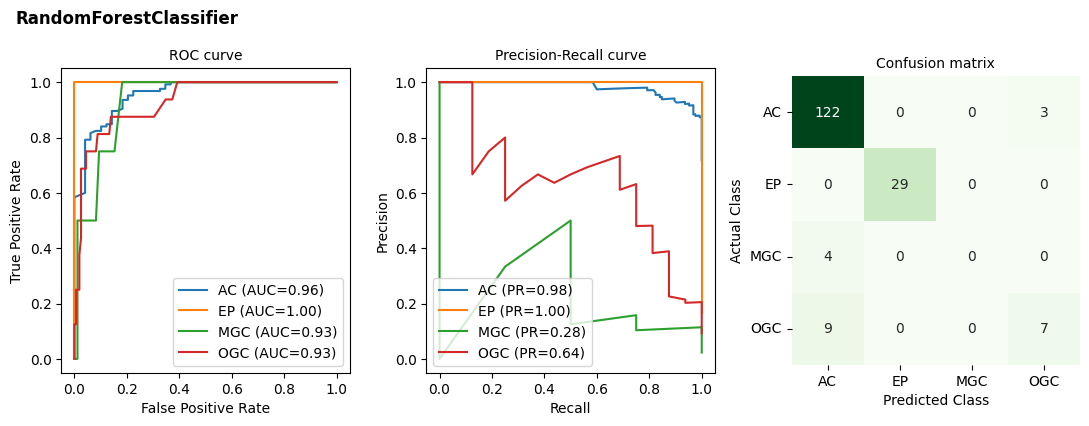

In [ ]:
performance_chart_report(rf, xtest[temp_features], ytest, display_labels)

In [218]:
eval_metrics(rf, xtest[temp_features], ytest)

,Accuracy,AUC,Recall,Precision,F1,Specificity
scores,0.908046,0.959538,0.908046,0.880247,0.890363,0.938274


In [219]:
print_classification_report(rf, xtest[temp_features], ytest)

                   precision    recall  f1-score   support

      astrocytoma       0.90      0.98      0.94       125
       ependymoma       1.00      1.00      1.00        29
    mixed gliomas       0.00      0.00      0.00         4
oligodendrocytoma       0.70      0.44      0.54        16

         accuracy                           0.91       174
        macro avg       0.65      0.60      0.62       174
     weighted avg       0.88      0.91      0.89       174



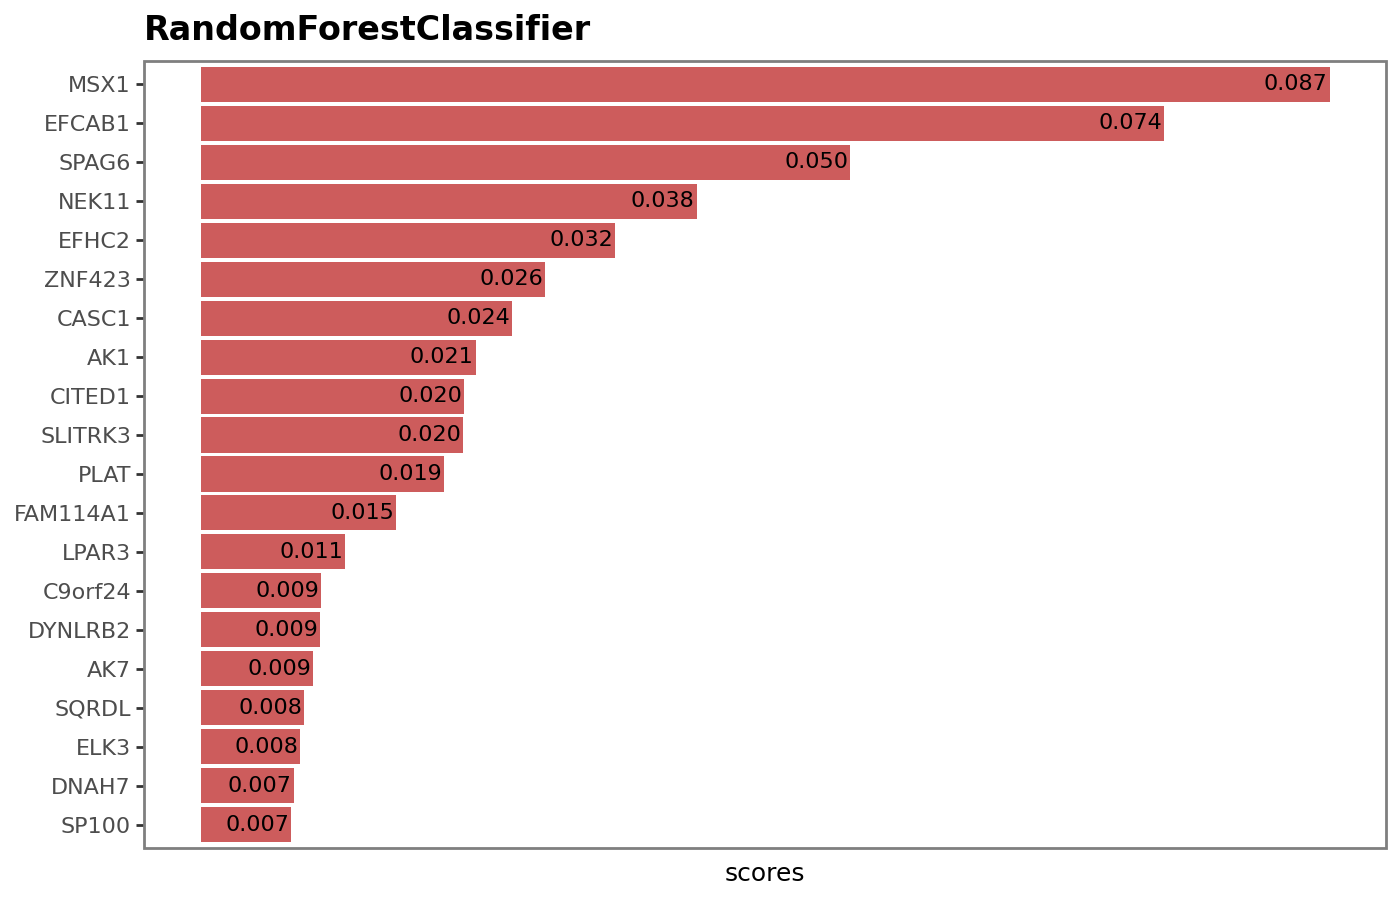

In [220]:
topn_importance(rf)

__Common features selected by both logistic regression and random forests models__

In [221]:
common_genes = list(set(temp_features).intersection(f))
print(len(sorted(common_genes)))

42


In [300]:
select_features_cell = [sorted(x) for x in select_features_cell]

In [304]:
# save files
with open('lr_model_gene_cell.csv', 'wt') as file:
    writer = csv.writer(file, lineterminator='\r')
    writer.writerows(select_features_cell)

with open('rf_model_gene_cell.csv', 'wt') as file:
    writer = csv.writer(file, lineterminator='\r')
    writer.writerows(temp_features)

with open('lr_rf_common_gene_cell.csv', 'wt') as file:
    writer = csv.writer(file, lineterminator='\r')
    writer.writerows(common_genes)

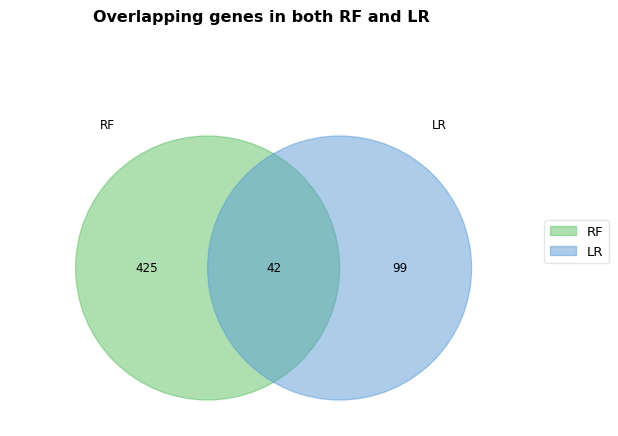

In [222]:
labs = venn.get_labels([temp_features, f], fill='number')
fig, ax = venn.venn2(labs, names=('RF', 'LR'), 
                     figsize=(10,5), fontsize=9)
fig.suptitle('Overlapping genes in both RF and LR', fontweight='bold');

### Feature Decompostion to reduce the number of features

- LDA

In [223]:
lda = LinearDiscriminantAnalysis()
lda.fit(xtrain, ytrain)
print(eval_metrics(lda, xtest, ytest))

        Accuracy       AUC   Recall  Precision        F1  Specificity
scores   0.83908  0.910898  0.83908   0.860096  0.845515     0.770723


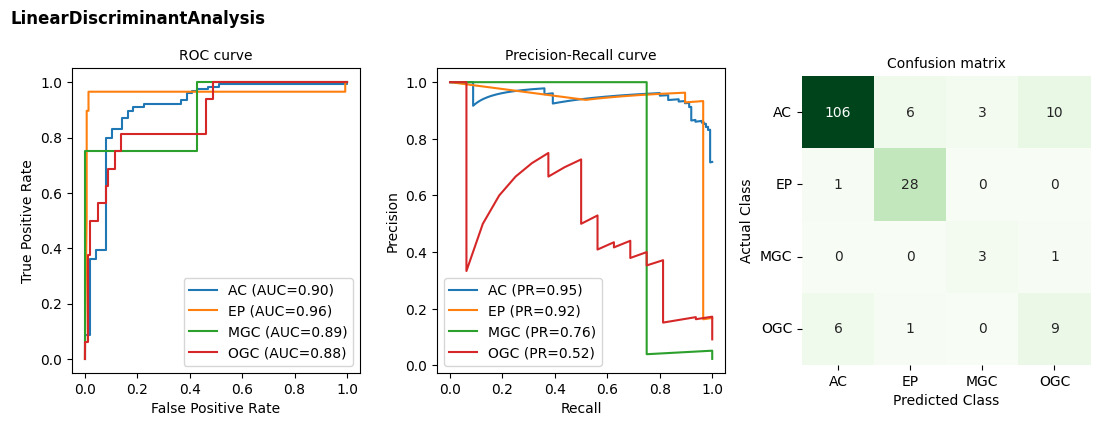

In [ ]:
performance_chart_report(lda, xtest, ytest, display_labels)

In [226]:
print_classification_report(lda, xtest, ytest)

                   precision    recall  f1-score   support

      astrocytoma       0.94      0.85      0.89       125
       ependymoma       0.80      0.97      0.88        29
    mixed gliomas       0.50      0.75      0.60         4
oligodendrocytoma       0.45      0.56      0.50        16

         accuracy                           0.84       174
        macro avg       0.67      0.78      0.72       174
     weighted avg       0.86      0.84      0.85       174



- PCA + kNN

In [227]:
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('scaler2', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [228]:
knn_params = {
    'pca__n_components' : np.arange(0.6,1,0.05),
    'knn__n_neighbors' : np.arange(3,15,2)
}

In [229]:
knn_res = tune_parameters(knn_pipe, xtrain, ytrain, knn_params)

In [230]:
knn_res.best_params_, knn_res.best_score_

({'knn__n_neighbors': 7, 'pca__n_components': 0.65}, 0.9240743861834829)

In [231]:
knn_res.cv_results_['mean_test_score']

array([0.91011302, 0.90525518, 0.89116239, 0.87642632, 0.86787621,
       0.82058457, 0.77347009, 0.75621553, 0.91753188, 0.91045344,
       0.89322882, 0.89249671, 0.88005035, 0.8397779 , 0.78737095,
       0.77154008, 0.91935643, 0.92407439, 0.8965692 , 0.89438271,
       0.86990854, 0.83381588, 0.78986349, 0.7397436 , 0.92004737,
       0.92165515, 0.90080596, 0.8926905 , 0.87591233, 0.84389142,
       0.81503748, 0.74196917, 0.91857625, 0.91662152, 0.91100674,
       0.89583764, 0.87542492, 0.85055537, 0.81609588, 0.73197348,
       0.91613747, 0.91413849, 0.91438606, 0.89808505, 0.87967812,
       0.86958061, 0.81770529, 0.73225104])

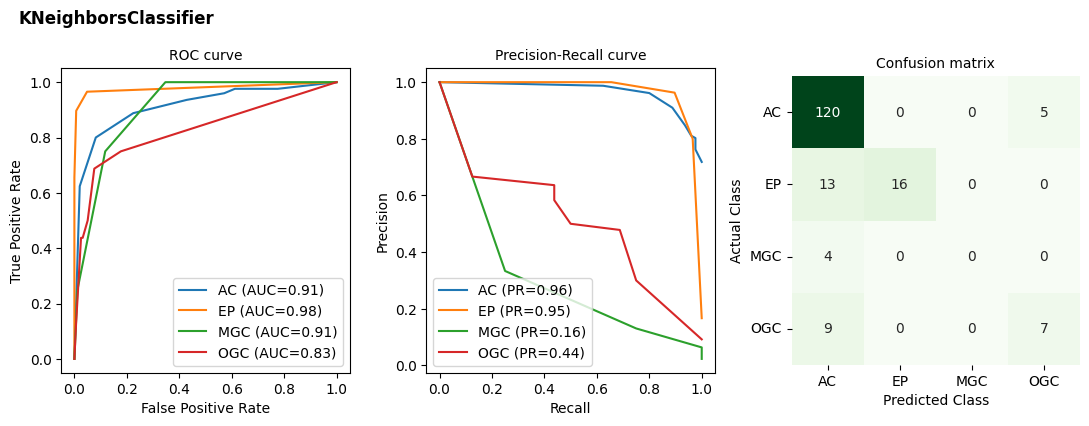

In [ ]:
performance_chart_report(knn_res.best_estimator_, xtest, ytest, display_labels) 
plt.suptitle('KNeighborsClassifier', x=0.11, fontweight='bold');

- LDA model was able to distinguish most mixed gliomas from the rest of the cancer cells, can we improve predictions using decomposed features?

In [234]:
xtrain_lda = lda.transform(xtrain)
xtest_lda = lda.transform(xtest)

- Logistic regression

In [271]:
lr_res = tune_parameters(lr_model, np.c_[xtrain[f].to_numpy(), xtrain_lda], ytrain, lambdas)

In [272]:
lr_res.best_params_, lr_res.best_score_

({'model__C': 0.5}, 0.988534127045004)

In [273]:
lr_res.best_estimator_.fit(np.c_[xtrain[f].to_numpy(), xtrain_lda], ytrain)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.5, max_iter=500, penalty='l1',
                                    random_state=42, solver='liblinear'))])

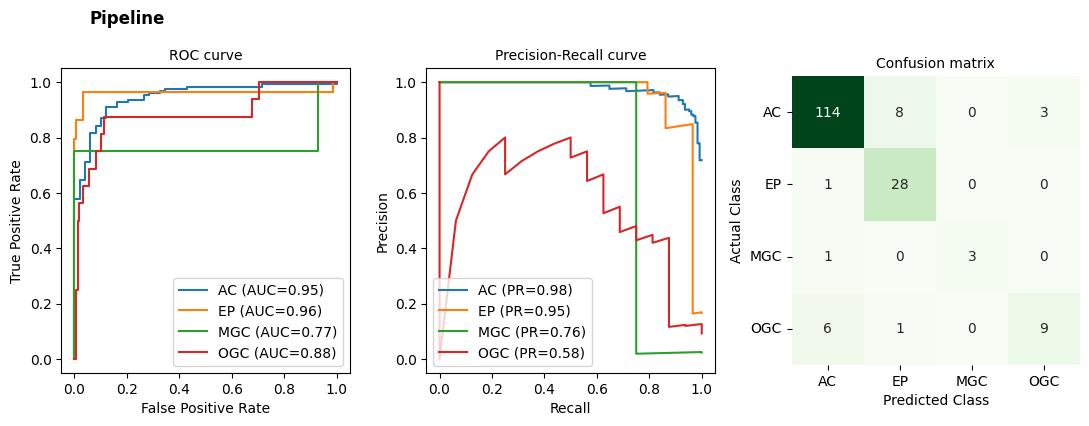

In [274]:
performance_chart_report(lr_res.best_estimator_, np.c_[xtest[f].to_numpy(), xtest_lda], ytest, display_labels)

In [305]:
eval_metrics(lr_res.best_estimator_, np.c_[xtest[f].to_numpy(), xtest_lda], ytest)

,Accuracy,AUC,Recall,Precision,F1,Specificity
scores,0.885057,0.938918,0.885057,0.889363,0.883362,0.842708


In [307]:
print_classification_report(lr_res.best_estimator_, np.c_[xtest[f].to_numpy(), xtest_lda], ytest)

                   precision    recall  f1-score   support

      astrocytoma       0.93      0.91      0.92       125
       ependymoma       0.76      0.97      0.85        29
    mixed gliomas       1.00      0.75      0.86         4
oligodendrocytoma       0.75      0.56      0.64        16

         accuracy                           0.89       174
        macro avg       0.86      0.80      0.82       174
     weighted avg       0.89      0.89      0.88       174



- Random forest model

In [276]:
rf_params = {
    'n_estimators': [400, 600],
    'max_features': [0.2, 0.4, 0.6],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [7, 10]
 }

In [277]:
rf_res = tune_parameters(rf, np.c_[xtrain[temp_features].to_numpy(), xtrain_lda], ytrain, rf_params)

In [278]:
rf_res.best_params_, rf_res.best_score_

({'max_features': 0.6,
  'min_samples_leaf': 7,
  'min_samples_split': 2,
  'n_estimators': 400},
 0.998385743937434)

In [279]:
rf.set_params(**{
    'max_features': 0.6,
    'min_samples_leaf': 7,
    'min_samples_split': 2,
    'n_estimators': 400
})

RandomForestClassifier(max_features=0.6, min_samples_leaf=7, n_estimators=400,
                       n_jobs=2, random_state=42)

In [280]:
rf.fit(np.c_[xtrain[temp_features].to_numpy(), xtrain_lda], ytrain)

RandomForestClassifier(max_features=0.6, min_samples_leaf=7, n_estimators=400,
                       n_jobs=2, random_state=42)

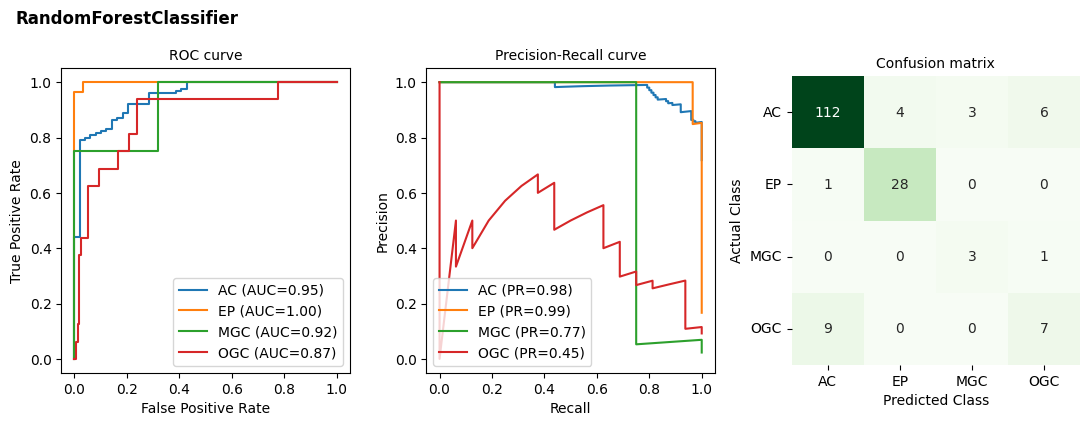

In [281]:
performance_chart_report(rf, np.c_[xtest[temp_features].to_numpy(), xtest_lda], ytest, display_labels)

In [306]:
eval_metrics(rf, np.c_[xtest[temp_features].to_numpy(), xtest_lda], ytest)

,Accuracy,AUC,Recall,Precision,F1,Specificity
scores,0.862069,0.947777,0.862069,0.862811,0.861207,0.813919


In [308]:
print_classification_report(rf, np.c_[xtest[temp_features].to_numpy(), xtest_lda], ytest)

                   precision    recall  f1-score   support

      astrocytoma       0.92      0.90      0.91       125
       ependymoma       0.88      0.97      0.92        29
    mixed gliomas       0.50      0.75      0.60         4
oligodendrocytoma       0.50      0.44      0.47        16

         accuracy                           0.86       174
        macro avg       0.70      0.76      0.72       174
     weighted avg       0.86      0.86      0.86       174

